In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
import time
import pandas as pd
from numpy.linalg import norm
from itertools import count
from IPython import display
import seaborn as sns
from IPython.display import HTML
from scipy.io import loadmat
from operator_functions.pointer_func import pointer_vector
from operator_functions.AB_operator import A_operator,B_operator,uBC_Laplace,b_vector_creator
from operator_functions.Conjugate_gradient import CG_solver_transient,CG_solver,CG_solver_transient_Matrix
from operator_functions.bound_append import bound_appender
from operator_functions.helper_util import Func_GaussElimination
import time
from joblib import Parallel, delayed


In [43]:
##diffusivity
alpha  = 0.005 ;
## Delta t
dt = 0.02 ;
## grid
Nx=19
Ny=19
xtotal  = np.linspace(0,1,Nx+2)
x=xtotal[1:Nx+1]
ytotal  = np.linspace(0,1,Ny+2)
y=ytotal[1:Ny+1]
dx = x[1] - x[0] 
dy=y[1] - y[0] 
xv, yv = np.meshgrid(x, y, indexing='ij')
X,Y=np.meshgrid(xtotal, ytotal, indexing='ij')
kappa=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
b=kappa/(alpha)
Q=np.zeros((Nx*Ny,1))
BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
cg_iter=10
b_residual_list=[]
cg_iter_list=[10,50,100,200,250]
#for cg_iter in cg_iter_list:
#    Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
#    b_residual_list.append(b_residual)
cg_iter=100
Steady_ss,Solution_Matrix,b_residual=CG_solver(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,cg_iter)
N=Nx*Ny
matrix_A=[]
matrix_B=[]

BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)

#for i in range(N):
#    Q=np.zeros((N,1))
#    Q[i,0]=1
#    matrix_A.append(list(A_operator(Q,Nx,Ny,dx,dy,dt,alpha)[:,0]))
    
#    Q=np.zeros((N,1))
#    Q[i,0]=1
#    matrix_B.append(list(B_operator(Q,Nx,Ny,dx,dy,dt,alpha)[:,0]))
#matrix_A=np.array(matrix_A)
#matrix_B=np.array(matrix_B)
#inv_B=np.linalg.inv(matrix_B)
#dt_range=[0.01,0.1,1,10]

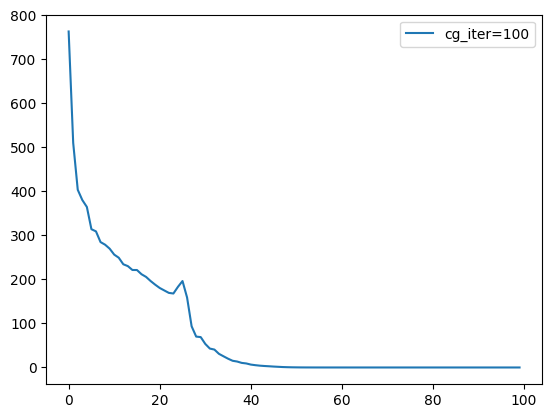

In [3]:
plt.plot([i for i in range(len(b_residual))],b_residual,label=f"cg_iter={cg_iter}")
plt.legend()
plt.show()

In [61]:
def timer_iteration(dt):
    kappa=dt*kappa_base
    Q=np.zeros((Nx*Ny,1))
    norm_list=[]
    b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    for it in range(100):
        b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
        Q,Solution_Matrix=CG_solver_transient(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
        norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
        if it%10==0:
            print(it*dt,norm_l2)
        norm_list.append(norm_l2)
        if norm_l2<1e-4:
            break
    return Q,norm_list

In [36]:
norm_list_total=[]
iter_list_total=[]
t = time.time()
results = Parallel(n_jobs=2)(delayed(timer_iteration)(dt) for dt in [0.1,1,5,10])
print(time.time()-t)

1259.428828239441


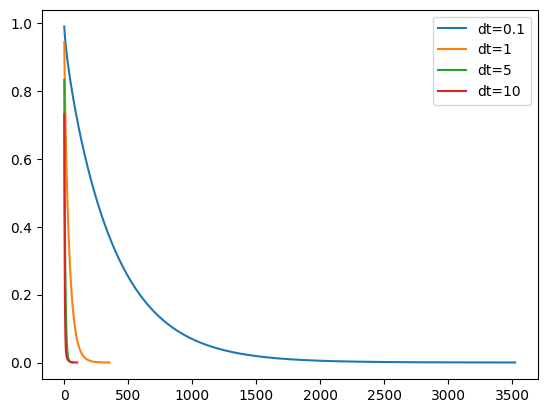

In [39]:
plt.plot([i for i in range(len(results[0]))],results[0],label=f"dt={dt_range[0]}")
plt.plot([i for i in range(len(results[1]))],results[1],label=f"dt={dt_range[1]}")
plt.plot([i for i in range(len(results[2]))],results[2],label=f"dt={dt_range[2]}")
plt.plot([i for i in range(len(results[3]))],results[3],label=f"dt={dt_range[3]}")
plt.legend()
plt.show()

In [14]:
norm_list_total=[]
iter_list_total=[]
kappa_base=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
dt_range=[5]
for dt in dt_range:
    ## grid
    kappa=dt*kappa_base
    Q=np.zeros((Nx*Ny,1))
    BCB=(-0.3)*np.ones(Nx)
    BCL=0.5-0.5*np.cos(2*np.pi*y)
    BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
    BCR=np.zeros(Ny)
    norm_list=[]
    iter_list=[]
    b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    for it in range(100):
        b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
        Q,Solution_Matrix=CG_solver_transient(Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
        norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
        if it%10==0:
            print(it*dt,norm_l2)
        norm_list.append(norm_l2)
        iter_list.append(it)
        if norm_l2<1e-4:
            break
    norm_list_total.append(norm_list)
    iter_list_total.append(iter_list)

0 0.8329621418933714
50 0.22243757584381435
100 0.060672940546942306
150 0.01655715348109416
200 0.004519780076824504
250 0.0012343534861591551
300 0.00033734665927693093
350 9.231549861495853e-05


In [ ]:
plt.plot([i for i in range(len(norm_list_total[0]))],norm_list_total[0],label=f"dt={dt_range[0]}")
plt.plot([i for i in range(len(norm_list_total[1]))],norm_list_total[1],label=f"dt={dt_range[1]}")
plt.plot([i for i in range(len(norm_list_total[2]))],norm_list_total[2],label=f"dt={dt_range[2]}")
plt.plot([i for i in range(len(norm_list_total[3]))],norm_list_total[3],label=f"dt={dt_range[3]}")
plt.legend()
plt.show()

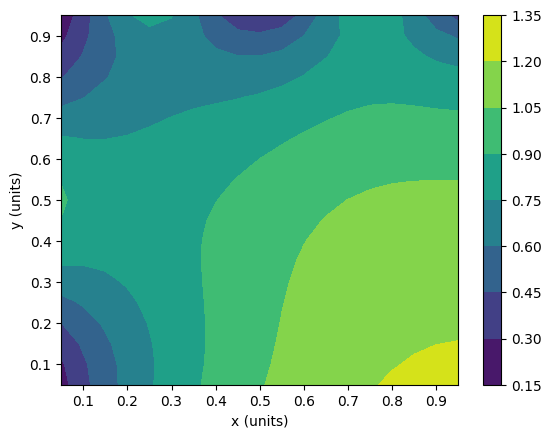

In [16]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, Solution_Matrix)
fig.colorbar(cp)
#ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [ ]:
norm_list_total=[]
iter_list_total=[]
kappa_base=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
## grid
dt=0.1
kappa=dt*kappa_base
Q=np.zeros((Nx*Ny,1))
BCB=(-0.3)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)
norm_list=[]
iter_list=[]
b_vector=b_vector_creator(kappa,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
for it in range(20000):
    b=A_operator(Q,Nx,Ny,dx,dy,dt,alpha)+b_vector
    Q=np.linalg.solve(matrix_B, b)
    #CG_solver_transient_Matrix(matrix_B,Q,b,Nx,Ny,dx,dy,BCB,BCL,BCT,BCR,dt,alpha)
    norm_l2 = (norm(Q-Steady_ss))/(norm(Steady_ss))
    if it%100==0:
        print(it*dt,norm_l2)
    norm_list.append(norm_l2)
    iter_list.append(it)
    if norm_l2<1e-4:
        break
norm_list_total.append(norm_list)
iter_list_total.append(iter_list)

In [ ]:
plt.plot([i for i in range(len(norm_list_total[0]))],norm_list_total[0],label=f"dt={dt_range[0]}")
#plt.plot([i for i in range(len(norm_list_total[1]))],norm_list_total[1],label=f"dt={dt_range[1]}")
#plt.plot([i for i in range(len(norm_list_total[2]))],norm_list_total[2],label=f"dt={dt_range[2]}")
#plt.plot([i for i in range(len(norm_list_total[3]))],norm_list_total[3],label=f"dt={dt_range[3]}")
plt.legend()
plt.show()